In [ ]:
# Cargar las librerias que he ido usando en el ejercicio

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import seaborn as sns
from datetime import datetime
import multiprocessing as mp


In [ ]:
#########################################################################

In [ ]:
#1. Trading con bandas de Bollinger.

In [ ]:
#1.1 Utilizando la API de IEX vista en clase descarga los precios de cierre del ETF
#del índice SP500 con ticker SPY. Guarda los datos en un csv para no tener que realizar
#la descarga cada vez (recuerda que tienes un limite).

In [ ]:
#1.1.1 Me bajo 5 anhos como se hablo en la clase
# crea un diccionario por cada uno de los acciones y crea el df
# solucion es df
def get_ticker_data(ticker, closeonly = True):   
    url = f'https://cloud.iexapis.com/stable/stock/{ticker}/chart'
    r = requests.get(url, params={
        'token': 'pk_885456f43fc8410db7e6d08a4a98f864',
        'chartCloseOnly': closeonly,
        'range': '5y',
    })
    
    print(r.content)###te sale el error si no te carga
    df = pd.read_json(r.content)
    df = df.set_index('date')
    if closeonly:
        return df.close
    return df




In [ ]:
#1.1.2 Lo guardo en variable sp_500
sp_500=get_ticker_data('SPY')

In [ ]:
#1.1.3 Compruebo data del sp_500 df
sp_500.head()

In [ ]:
sp_500.tail()

In [ ]:
#1.1.3 Guardo el fichero en un csv
data_sp_500 = sp_500.to_csv('data_sp_500.csv')
# A partir de ahora trabajo con el df data

In [2]:
#1.1.4 Abro el fichero csv y asi no gasto mas token
data = pd.read_csv('data_sp_500.csv')

In [ ]:
#compruevo que es equivalente

In [63]:
#1.1.4 compruevo que es equivalente muy por encima
#data.head()
#data.tail()
#sp_500.describe()
data.describe()

,close
count,1260.000000
mean,327.183659
std,70.059490
min,222.950000
25%,273.037500
50%,297.485000
75%,387.567500
max,477.710000


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(-200.0, 0, '2021-08-06'),
  Text(0.0, 0, '2017-05-22'),
  Text(200.0, 0, '2018-03-08'),
  Text(400.0, 0, '2018-12-21'),
  Text(600.0, 0, '2019-10-09'),
  Text(800.0, 0, '2020-07-27'),
  Text(1000.0, 0, '2021-05-12'),
  Text(1200.0, 0, '2022-02-25'),
  Text(1400.0, 0, '')])

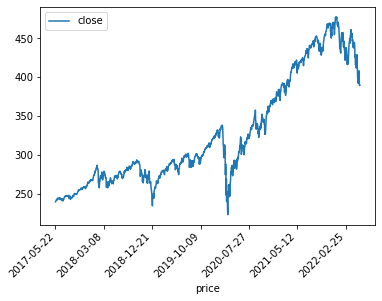

In [3]:
# 1.1.5 Grafico data para visualizarla

data_2 = data[:]
data_2.index = data_2.date
data_2.plot()
plt.xlabel('date')
plt.xlabel('price')
plt.xticks(rotation = 45, ha = "right")

In [ ]:
# He comprobado que data y sp_500 son equivalentes

In [ ]:
#1.2 Calcula las bandas de Bollinger. Las bandas Bollinger se calculan como MA−Kσ
#y MA + Kσ, donde MA es la media m´ovil de 30 muestras sobre el precio, σ es la
#desviación típica móvil de 30 muestras sobre el precio y K = 2.s

In [4]:
# En función
def bandas_boolinger(data,k,mv_avg_factor,std_ret_factor):
# Extraemos los datos de data
    price = data

# Calculamos la media rolada y la volatilidad a 30 días
    mv_avg = price.rolling(30).mean()
    std_ret = price.rolling(30).std()
    mv_avg = mv_avg * mv_avg_factor # modificada
    std_ret = std_ret * std_ret_factor # modificada
# Sobre la media rolada, calculamos + - 2 desviaciones típicas
    upper_band = mv_avg + k * std_ret
    lower_band = mv_avg - k * std_ret

# Correcto nombre a cols
    mv_avg_2 = mv_avg.rename(columns = {'close':'mv_avg'})
    std_ret_2 = std_ret.rename(columns = {'close':'std_ret'})
    upper_band_2 = upper_band.rename(columns = {'close':'upper_band'})
    lower_band_2 = lower_band.rename(columns = {'close':'lower_band'})

# Creo columnas auxiliares comprar y vender para tenerlo todo en un df
    comprar = upper_band.rename(columns = {'close':'comprar'})
    comprar[:] = np.nan
    vender = upper_band.rename(columns = {'close':'vender'})
    vender[:] = np.nan

# Ponerlo en un solo df para guardar todos los valores 
# Por si luego lo uso
    figure = pd.concat([price, mv_avg_2, std_ret_2, upper_band_2, 
    lower_band_2,comprar,vender],axis = 1)
    figure.index = figure.date

    return figure


figure = bandas_boolinger(data,2,1,1)


<AxesSubplot:xlabel='date'>

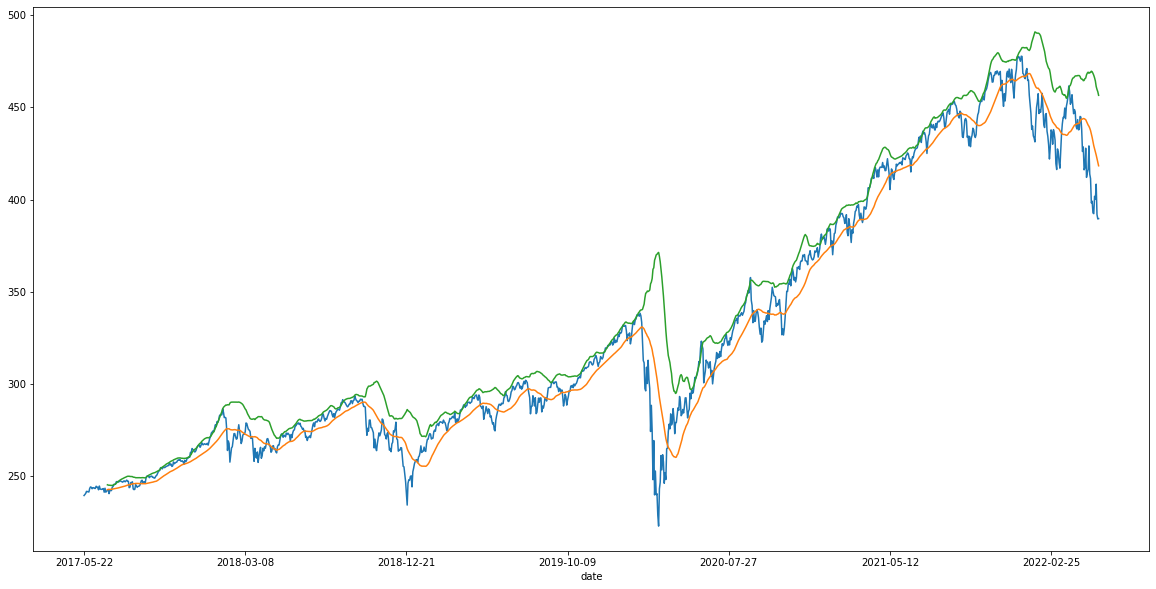

In [87]:
# 1.3 Realiza una figura del apartado anterior
figure_representa = figure.iloc[:,1:5][:]
figure_representa.pop('std_ret')
figure_representa.plot(figsize = (20,10),legend = None)

In [5]:
# El punto 1.4 en funcion
def comprar_vender (figure):

#1.4  Usando las bandas de Bollinger, calcula cuando comprar 
# y vender un activo. Compramos cuando
# el precio del activo sale y vuelve a entrar en la banda inferior, 
# y vendemos cuando
# toca la banda superior.
# Si estamos comprando, no volvemos a comprar

# Detectamos todas las veces que close > lower_band y el anterior 
# no lo era. Y lo guardo en lower_band.
# Detectamos todas las veces que close > upper_band y el anterior 
# no lo era. Y lo guardo en upper_band.

    lower_band = list()
    lower_band_precio = list()
    upper_band = list()
    upper_band_precio = list()
#flags para decir si lo que busco es comprar o lo que busco en vender
    flag_compro_vendo = 1 #0 compro y espero a vender y 1 vendo y espero a comprar
    
    for i in range(30,len(figure.index)):
        if (figure.close[i] > figure.lower_band[i]) & \
            (figure.close[i - 1] < figure.lower_band[i - 1]) & \
            (flag_compro_vendo == 1):
                #entonces compro dia sigu (i+1),que como solo tengo el
                #valor de close, pues seria al valor de close
                #print("lower_band", figure.index[i])            
                lower_band.append(figure.index[i + 1])
                lower_band_precio.append(figure.close[i + 1])
                #print(figure.close[i])
                # en comprar pongo el valor de close. Si no me da un warning.
                figure.iloc[i + 1,6] = figure.iloc[i + 1,1] 
                flag_compro_vendo = 0
                
        if (figure.close[i] > figure.upper_band[i]) & \
            (figure.close[i - 1] < figure.upper_band[i - 1]) & \
            (flag_compro_vendo == 0): 
               # entonces vendo el dia siguiente (i+1), que como solo tengo el valor 
               # de close, pues seria al valor de close
               #print("upper_band", figure.index[i])
                upper_band.append(figure.index[i + 1])
                upper_band_precio.append(figure.close[i + 1])
               #print(figure.close[i])
               # en vender pongo el valor de close. Si no me da un warning.
                figure.iloc[i + 1,7] = figure.iloc[i + 1,1] 
                flag_compro_vendo = 1

# Me termina el programa con una compra y no he podido vender.
# Entinonces incluyo las siguientes funciones para borrar esa compra si 
# al final no se puede vender.
# La elimina de las listas y del df figure.comprar
    #print(lower_band[ - 1])
    if flag_compro_vendo == 0:
        figure.iloc[:,6][figure.iloc[:,0] == lower_band[ - 1]] = np.nan
        #figure.loc[:,'comprar'][figure.loc[:,'date'] == lower_band[ - 1]] = np.nan
        # No he podido quitarme este warning. Solo estoy haciendo una mascara booleriana
        #pero de da el warning
        lower_band.pop()
        lower_band_precio.pop()
        
    
    #print(figure.iloc[:,6])
    #print(lower_band_precio)
    #print(upper_band)
    #print(upper_band_precio)
    # aunque tengo listas auxiliares; al final todo guardado en df figure
    numero_inversiones = len(lower_band)
        
    return figure,upper_band_precio,upper_band,lower_band_precio,lower_band,numero_inversiones


figure,upper_band_precio,upper_band,lower_band_precio,lower_band,numero_inversiones = comprar_vender(figure)

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_7868/3530936680.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  figure.iloc[:,6][figure.iloc[:,0] == lower_band[ - 1]] = np.nan


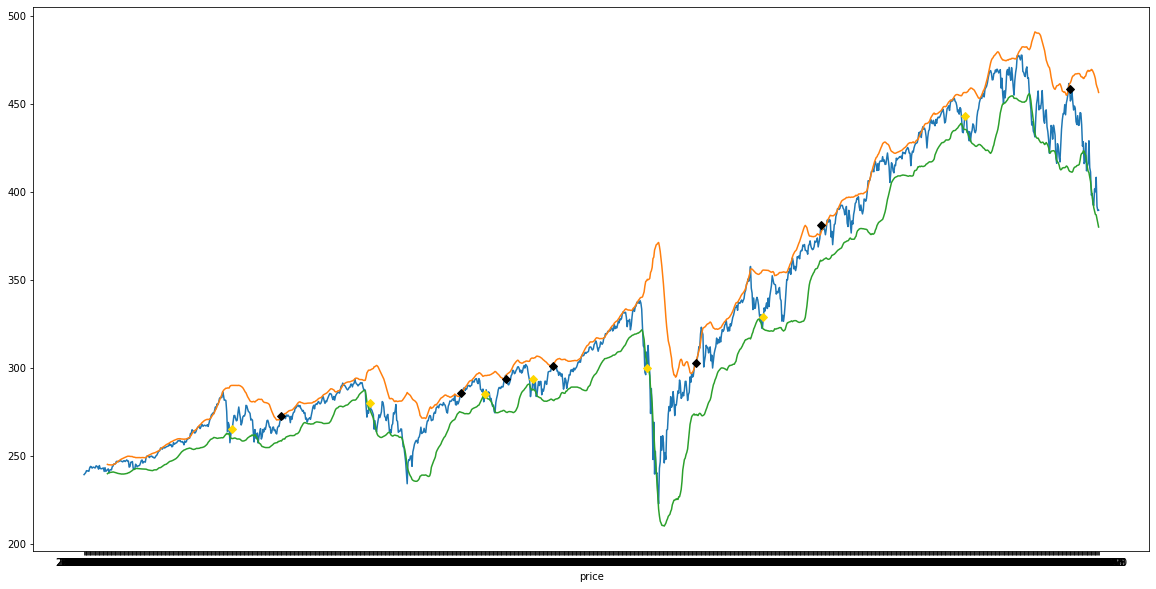

In [89]:
#1.5.
# Realiza la figura del apartado anterior.
#Intenta obtener algo parecido a la Figure 1.
# Ponerlo en un solo df para representar los valores como 
#figure 1 de enunciado
# Si lo hago desde el df figure, las ordenadas no salen bien. 
#Por eso hago por list

def graf_band_boll_comprar_vender (figure):

    fig, ax = plt.subplots(figsize = (20,10),sharex = True)
    ax.plot(figure.close)
    ax.plot(figure.upper_band)
    ax.plot(figure.lower_band)
    plt.xlabel('date')
    plt.xlabel('price')
#shareybool, default False


#Amarillo es de comprar
    ax.plot(figure.comprar, 
        color = 'gold' ,  # Línea de color oro
        linestyle = 'dashed', # Línea discontinua
        marker = 'D') # Con rombos

#negro es de vender
    ax.plot(figure.vender, 
        color = 'black', # Línea de color oro
        linestyle = 'dashed', # Línea discontinua
        marker = 'D') # Con rombos
    
    return 

graf_band_boll_comprar_vender(figure)

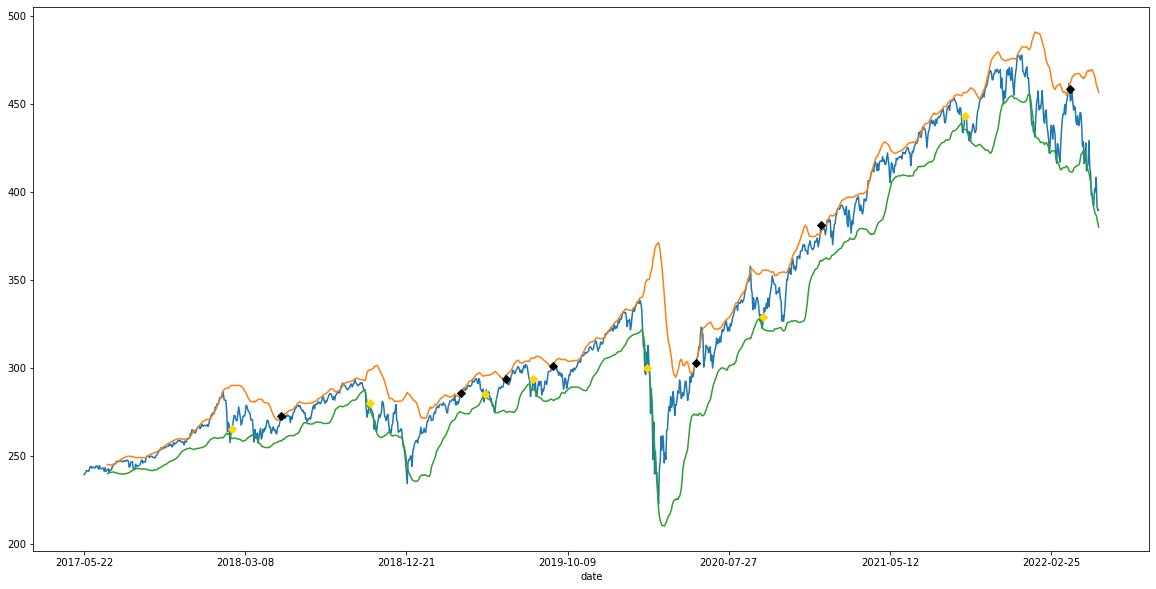

In [6]:

# Y esta segunda version es mejor en el eje de las x y mas rapida

def graf_band_boll_comprar_vender_2 (figure):
    figure_2 = figure[:]
    del figure_2['mv_avg']
    del figure_2['std_ret']
    del figure_2['date']
    figure_2
    figure_2.plot(figsize = (20,10),legend = None)
    #Amarillo es de comprar
    figure.comprar.plot(color = 'gold', # Línea de color oro
    linestyle = 'dashed', # Línea discontinua
    marker = 'D') # Con rombos

    #negro es de vender
    figure.vender.plot(color = 'black', # Línea de color oro
        linestyle = 'dashed', # Línea discontinua
        marker = 'D') # Con rombos

    return
graf_band_boll_comprar_vender_2(figure)

In [8]:
#1.6 Calcula la rentabilidad media por operacion en una funcion 
def rentabilidad_media_por_operacion (upper_band_precio,lower_band_precio):
    data = {'upper_band_precio': upper_band_precio,
            'lower_band_precio': lower_band_precio}
    frame_2 = pd.DataFrame(data)
    f = lambda x:(x.upper_band_precio / x.lower_band_precio) -1
    return (frame_2.apply(f,axis = 1).mean())

rent_media = rentabilidad_media_por_operacion (upper_band_precio,
lower_band_precio)

print('La rentabilidad media por operacion es ',rent_media)


La rentabilidad media por operacion es  0.044099711006651256


In [ ]:
#1.7 Intenta optimizar los parametros que quieras del calculo de las bandas

#Se puede modificar
#- mv_avg, figure.mv_avg.mean() es 326.4
#- K, originalmente es 2
#- std_ret,figure.std_ret.mean() es 6.65
#Usar multiprocesing da punto extra

In [9]:
# Al ir iterando, he comprobado que si pongo pesos a mv_avg diferente a 1, no me hace el calculo bien
# Al ir iterando, he comprobado que K a partir de 2.8, no me hace los calculos bien.
# Al ir iterando, he comprobado que std_re a partir de 2,8, no me hace los calculos bien.
# Entonces creo una tabla con valores de dos en dos de 0.2 a 2.8 de los valores K y un factor que multiplica a std_ret

data_iterar = {'k': ['0.2','0.4','0.6','0.8','1','1.2','1.4',
'1.6','1.8','2','2.2','2.4','2.6','2.8'],
            'q': ['0.2','0.4','0.6','0.8','1','1.2','1.4',
'1.6','1.8','2','2.2','2.4','2.6','2.8']}
frame_iterar = pd.DataFrame(data_iterar)
#lista = list()
k = 0 #k
#p = 0 #mv_avg_factor
q = 0 #std_ret_factor

renta_media_lista = []
contador  = 0

li = [0] * 196
da = {'rent_media': li ,
        'K': li,
        'std_ret_factor': li}
resultados = pd.DataFrame(da)


for i in range(0,len(frame_iterar)):
    for j in range(0,len(frame_iterar)):
        
        figure = bandas_boolinger(data,float(frame_iterar.iloc[i,0]),1,float(frame_iterar.iloc[j,1]))
        figure,upper_band_precio,upper_band,lower_band_precio,lower_band,numero_inversiones = comprar_vender(figure)
        rent_media = rentabilidad_media_por_operacion (upper_band_precio, lower_band_precio)
        # cuando ya no detecta comprar_vender ninguna compra, me da un error
        # asignando ningun valor a upper_band_precio, lower_band_precio y posteriormente a rent_media. Por eso hago esta excepcion
        try:
            renta_media_lista.append(rent_media)
            resultados.iloc[contador,0] = rent_media
            resultados.iloc[contador,1] = frame_iterar.iloc[i,0]
            resultados.iloc[contador,2] = frame_iterar.iloc[j,1]
        except ValueError as e:
            resultados.iloc[contador,0] = 0
            renta_media_lista.append(0)
        contador = contador + 1
        
#Elimino los cerros que son las finlas no rellenadas
resultados = resultados[resultados.iloc[:,1] != 0]

#Resultados
print("El mejor rendimiento se produce con la rentabilidad media de:")
print(max(resultados.rent_media)) 
print("En los siguientes valores")
print(resultados[resultados.rent_media==max(resultados.rent_media)])
 

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_7868/3530936680.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  figure.iloc[:,6][figure.iloc[:,0] == lower_band[ - 1]] = np.nan


El mejor rendimiento se produce con la rentabilidad media de:
0.4630084420567919
En los siguientes valores
     rent_media    K std_ret_factor
68     0.463008    1            2.6
80     0.463008  1.2            2.2
92     0.463008  1.4            1.8
105    0.463008  1.6            1.6
118    0.463008  1.8            1.4
145    0.463008  2.2            1.2
172    0.463008  2.6              1


In [ ]:
# Conclusiones:
# Al ir iterando, he comprobado que si pongo pesos a mv_avg diferente a 1, no me hace el calculo bien
# Al ir iterando, he comprobado que K a partir de 2.8, no me hace los calculos bien.
# Al ir iterando, he comprobado que std_re a partir de 2,8, no me hace los calculos bien.
# Cuando ya no detecta comprar_vender ninguna compra, me da un error
# asignando ningun valor a upper_band_precio, lower_band_precio y posteriormente a rent_media.

In [ ]:
# Con multiprocesing
# NO VA. LO INTENTÉ POR MILES DE MANERA Y
# NO ME LEE BIEN LOS VALORES  k Y q
# POR LO TANTO ME DA SOLUCIONES resultado VACIOS
# LO PUSE TODO EN UN .PY Y HE USADO SPYDER Y NO LO CONSEGUI
# NO ENTIENDO PQ LA FUNCION bandas_boolinger NO ME LEE BIEN LOS VALORES k Y q.
import itertools
k = [0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8]
q = [0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8]
all_combinations = itertools.product(k, q) 
print(list(all_combinations)) 

def func_total (k,q):
    figure = bandas_boolinger(data,float(k),1,float(q))
    figure,upper_band_precio,upper_band,lower_band_precio,lower_band,numero_inversiones = comprar_vender(figure)
    #graf_band_boll_comprar_vender_2(figure)
    rent_media = rentabilidad_media_por_operacion (upper_band_precio, lower_band_precio)
    
    return rent_media,figure

import multiprocessing as mp
#llamar a la función func_total con multiprocesing
pool = mp.Pool(2) 
resultado,figure = pool.starmap(func_total, all_combinations)

